In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import asteroseismology as se
import warnings
warnings.filterwarnings("ignore")
import arviz as az

In [2]:
Dnu, e_Dnu = 89.5, 0.5
numax, e_numax = 1850, 47
Teff, e_Teff = 5884, 4.4 #https://www.aanda.org/articles/aa/pdf/2003/46/aa3944.pdf
# eps = 1.2-1.6
mass = 1.14

In [3]:
# read in power spectrum
data = pd.read_csv('data/HD141004_PS_os1.txt', delimiter=' ', names=['freq', 'psd'], skiprows=1)
data['psds'] = se.smoothWrapper(data['freq'].to_numpy(), data['psd'].to_numpy(), Dnu*0.02, 'bartlett')

(0.0, 40.0)

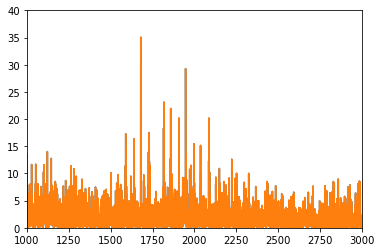

In [4]:
plt.plot(data['freq'], data['psd'])
plt.plot(data['freq'], data['psds'])
plt.xlim(1000,3000)
plt.ylim(0,40)

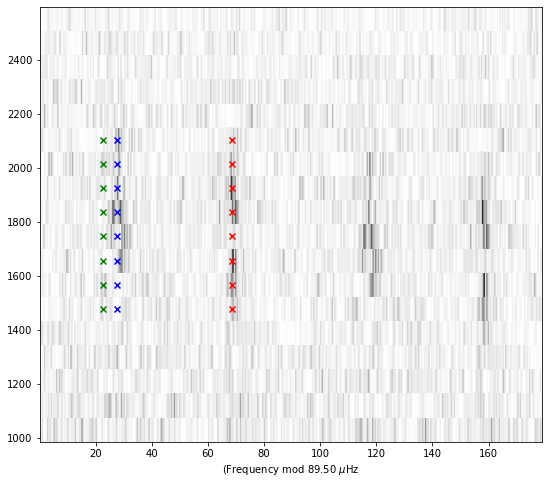

In [5]:
fig = plt.figure(figsize=(9,8))
ax1 = fig.add_subplot(111)
echx, echy, echz = se.echelle(data['freq'].to_numpy(),
                              data['psds'].to_numpy(),
                              Dnu, 
                              numax-9.0*Dnu,
                              numax+9.0*Dnu,
                              echelletype="replicated",
                              offset=0.)
levels = np.linspace(np.min(echz),np.max(echz),500)
ax1.contourf(echx,echy,echz,cmap="gray_r",levels=levels)
ax1.axis([np.min(echx),np.max(echx),np.min(echy),np.max(echy)])

ax1.set_xlabel("(Frequency mod {:0.2f} $\mu$Hz".format(Dnu))

ns = np.arange(0, 8)+16
eps = 0.31
dnu02 = 5.
dnu01 = 4
fc0 = Dnu*(ns+eps)
fc2 = fc0 - dnu02
fc1 = fc0 + Dnu/2. - dnu01

ax1.scatter(fc0%Dnu, fc0-fc0%Dnu+0.5*Dnu, marker='x', color='b')
ax1.scatter(fc2%Dnu, fc2-fc2%Dnu+0.5*Dnu, marker='x', color='g')
ax1.scatter(fc1%Dnu, fc1-fc1%Dnu+0.5*Dnu, marker='x', color='r')

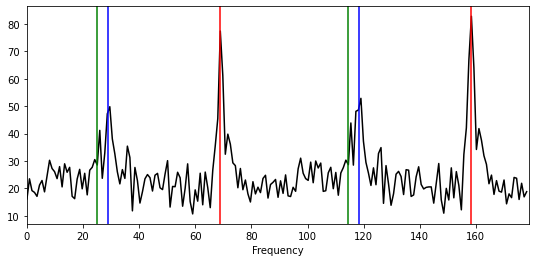

In [6]:
freqc = np.arange(0, Dnu*2, Dnu/100)
powerc = np.zeros(len(freqc))
fmin = 10*Dnu
for i in range(11):
    powerc += np.interp(fmin+i*Dnu+freqc, data['freq'].to_numpy(), data['psds'].to_numpy())


fig = plt.figure(figsize=(9,4))
ax1 = fig.add_subplot(111)
ax1.plot(freqc, powerc, 'k')
ax1.set_xlim(0, 2*Dnu)
ax1.set_xlabel("Frequency")

ax1.axvline(29, color='b', label='l=0')
ax1.axvline(29+Dnu, color='b', label='l=0')

ax1.axvline(29+Dnu/2.-5, color='r', label='l=1')
ax1.axvline(29+Dnu/2.+Dnu-5, color='r', label='l=1')

ax1.axvline(29-4, color='g', label='Possibly l=2')
ax1.axvline(29+Dnu-4, color='g', label='Possibly l=2')

In [34]:
import pymc

idx = (data['freq'] >1250) & (data['freq']<2400)
x = data.loc[idx,'freq'].to_numpy()
y = data.loc[idx,'psd'].to_numpy()

with pymc.Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # hyper-parameters (priors)
    
    
    Dnu_g, numax_g = 89.5, 1850
    e_Dnu_g, e_numax_g = 0.5, 47
    
    Nmode = 8
    ns = np.arange(0, 8) + 16
    
    Dnu = pymc.TruncatedNormal('Dnu', mu=Dnu_g, sigma=e_Dnu_g, lower=Dnu_g-2*e_Dnu_g, upper=Dnu_g+2*e_Dnu_g, shape=1)
    # numax = pymc.Normal('numax', mu=, sigma=)
    eps = pymc.Uniform('eps', lower=0.31-0.2, upper=0.31+0.2, shape=1)
    # alpha = pymc.HalfCauchy('alpha', beta=0.1, shape=1)
    # dnu02 = pymc.TruncatedNormal('dnu02', mu=10., sigma=0.02*Dnu_g, lower=0., upper=0.5*Dnu_g, shape=1)
    dnu01 = pymc.TruncatedNormal('dnu01', mu=10./3., sigma=0.02*Dnu_g, lower=0., upper=0.5*Dnu_g, shape=1)
    
    bg = pymc.Uniform('bg', lower=0., upper=5, shape=1)
    
    A = pymc.Normal('A', mu=4, sigma=2, shape=1)
    w = pymc.Normal('w', mu=np.e**(0.9638*np.log(numax_g)-1.7145), sigma=Dnu_g*2, shape=1)

    # lw_a = pymc.Uniform('lw_a', lower=0, upper=10, shape=1)
    # lw_Ga = pymc.Uniform('lw_Ga', lower=0, upper=100, shape=1)
    
    fc0 = pymc.Normal('fc0', mu=Dnu*(ns+eps), sigma=3.0, shape=Nmode) 
    # fc2 = pymc.Normal('fc2', mu=Dnu*(ns+eps)-dnu02, sigma=Dnu*0.02, shape=Nmode) 
    fc1 = pymc.Normal('fc1', mu=Dnu*(ns+eps+0.5)-dnu01, sigma=3.0, shape=Nmode) 
    
    amp0 = pymc.Normal('amp0', mu=A*np.e**(-(fc0-numax_g)**2.0/(2*w**2.0)), sigma=0.5*A*np.e**(-(fc0-numax_g)**2.0/(2*w**2.0)), shape=Nmode)
    # amp2 = pymc.Normal('amp2', mu=A*np.e**(-(fc2-numax_g)**2.0/(2*w**2.0))*0.6, sigma=0.1*A*np.e**(-(fc2-numax_g)**2.0/(2*w**2.0))*0.6, shape=Nmode)
    amp1 = pymc.Normal('amp1', mu=A*np.e**(-(fc1-numax_g)**2.0/(2*w**2.0))*1.3, sigma=0.5*A*np.e**(-(fc1-numax_g)**2.0/(2*w**2.0))*1.3, shape=Nmode)
    
    lw0 = pymc.HalfNormal('lw0', sigma=2, shape=Nmode)
    # lw2 = pymc.HalfNormal('lw2', sigma=1, shape=Nmode)
    lw1 = pymc.HalfNormal('lw1', sigma=2, shape=Nmode)
    
    # parameters (priors)
    power_model = 0 
    for imode in range(Nmode):
        power_model += (2*amp0[imode]**2.0/(np.pi*lw0[imode]))/(1+(x-fc0[imode])**2.0/lw0[imode]**2.0)
        # power_model += (2*amp2[imode]**2.0/(np.pi*lw2[imode]))/(1+(x-fc2[imode])**2.0/lw2[imode]**2.0)
        power_model += (2*amp1[imode]**2.0/(np.pi*lw1[imode]))/(1+(x-fc1[imode])**2.0/lw1[imode]**2.0)
    power_model += bg
    
    # model match observation (likelihood)
    likelihood = pymc.Gamma('likelihood', alpha=1., beta=1./power_model, observed=y)
    
    # inference, draw 3000 posterior samples using NUTS sampling
    idata = pymc.sample(15000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Dnu, eps, dnu01, bg, A, w, fc0, fc1, amp0, amp1, lw0, lw1]


/Users/yaguang/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/yaguang/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/yaguang/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/yaguang/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 15_000 draw iterations (4_000 + 60_000 draws total) took 758 seconds.
There were 316 divergences after tuning. Increase `target_accept` or reparameterize.
There were 288 divergences after tuning. Increase `target_accept` or reparameterize.

In [59]:
import arviz as az
az.to_netcdf(idata, 'samples.netcdf')

'samples.netcdf'

In [7]:
idata = az.from_netcdf('samples.netcdf')

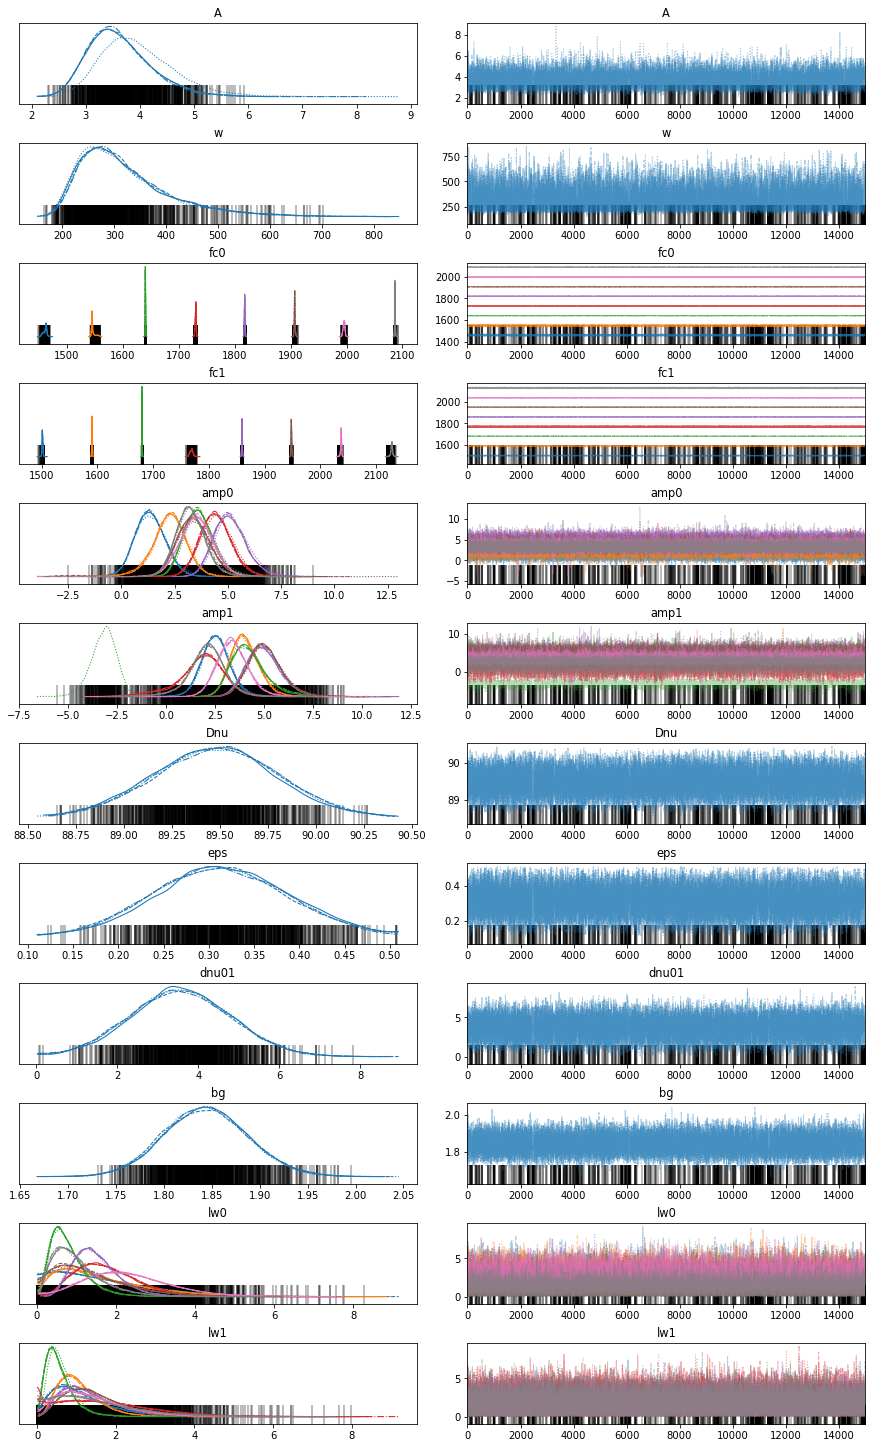

In [8]:
az.plot_trace(idata, figsize=(12, 20), backend_kwargs={'constrained_layout':True})
# az.plot_posterior(idata)
params = az.summary(idata, stat_focus="median")
paramsMedian = params['median']
paramsErr = params['mad']

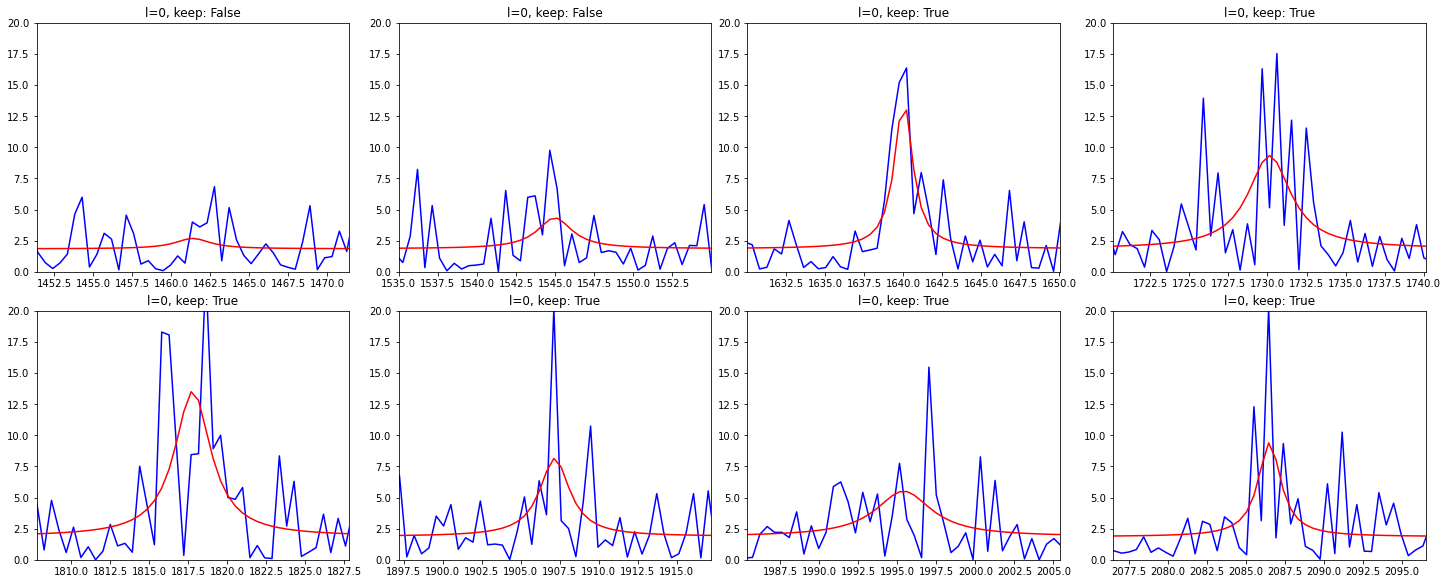

In [134]:
# idx = (SNRdata[:,0]>320) & (SNRdata[:,0]<333)

idx = (data['freq'] >1250) & (data['freq']<2400)
x = data.loc[idx,'freq'].to_numpy()
y = data.loc[idx,'psd'].to_numpy()
    
Nmode = 8
# yfit = paramsMedian['H']/(1+(x-paramsMedian['fc'])**2.0/paramsMedian['lw']**2.0) + 1

yfit = paramsMedian['bg[0]']
for imode in range(Nmode):
    # power_model += (2*amp0[imode]**2.0/(np.pi*lw0[imode]))/(1+(x-fc0[imode])**2.0/lw**2.0)
    yfit += (2*paramsMedian[f'amp0[{imode}]']**2.0/(np.pi*paramsMedian[f'lw0[{imode}]']))/(1+(x-paramsMedian[f'fc0[{imode}]'])**2.0/paramsMedian[f'lw0[{imode}]']**2.0)
    yfit += (2*paramsMedian[f'amp1[{imode}]']**2.0/(np.pi*paramsMedian[f'lw1[{imode}]']))/(1+(x-paramsMedian[f'fc1[{imode}]'])**2.0/paramsMedian[f'lw1[{imode}]']**2.0)
    # yfit += (2*paramsMedian[f'amp2[{imode}]']**2.0/(np.pi*paramsMedian[f'lw2[{imode}]']))/(1+(x-paramsMedian[f'fc2[{imode}]'])**2.0/paramsMedian[f'lw2[{imode}]']**2.0)

ncols, nrows = 4, 2
fig, axes = plt.subplots(figsize=(5*ncols, 4*nrows), nrows=nrows, ncols=ncols, constrained_layout=True)
axes = axes.reshape(-1)
for iax, ax in enumerate(axes):
    ax.plot(x, y, 'b-', label="sampled data")
    ax.plot(x, yfit, 'r-', label="fitted data")
    ax.set_xlim(paramsMedian[f'fc0[{iax}]']-10, paramsMedian[f'fc0[{iax}]']+10)
    idx = (x>(paramsMedian[f'fc0[{iax}]']-10)) & (x<(paramsMedian[f'fc0[{iax}]']+10))
    ax.set_ylim(0., 20)
    keep = False if iax in [0,1] else True
    ax.set_title('l=0, keep: {}'.format(keep))
# plt.legend(loc=0);

plt.savefig('plot_l0_fits.jpg')


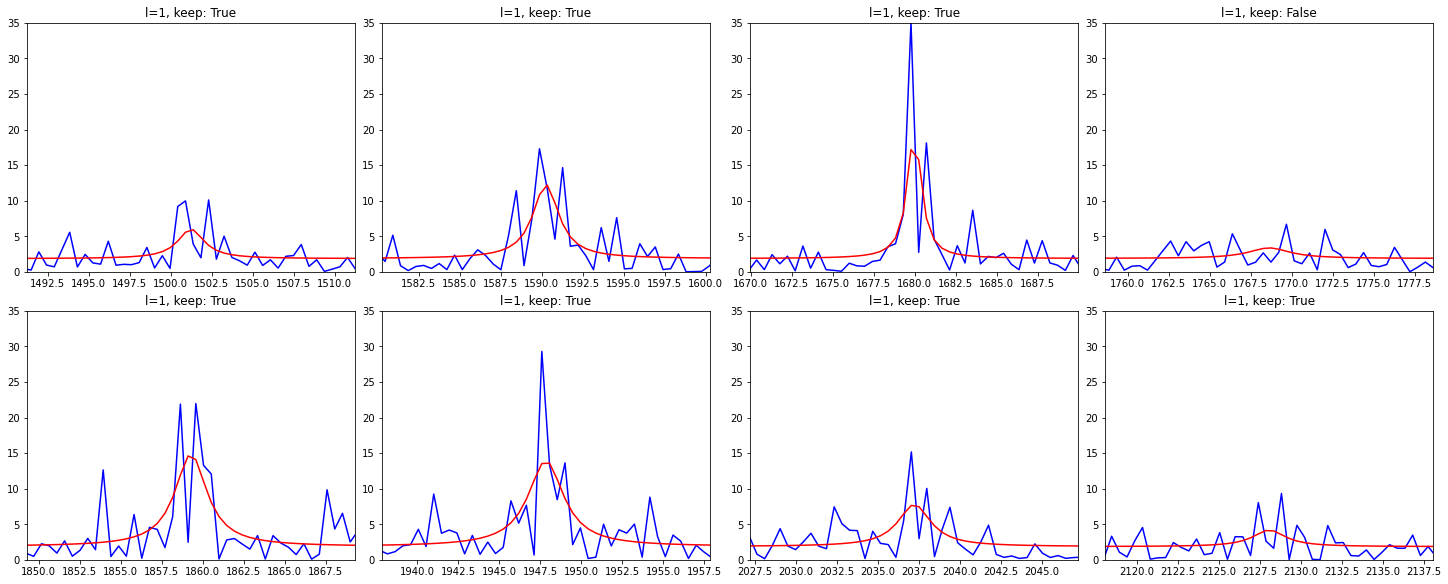

In [135]:
# idx = (SNRdata[:,0]>320) & (SNRdata[:,0]<333)

idx = (data['freq'] >1250) & (data['freq']<2400)
x = data.loc[idx,'freq'].to_numpy()
y = data.loc[idx,'psd'].to_numpy()
    
Nmode = 8
# yfit = paramsMedian['H']/(1+(x-paramsMedian['fc'])**2.0/paramsMedian['lw']**2.0) + 1

yfit = paramsMedian['bg[0]']
for imode in range(Nmode):
    # power_model += (2*amp0[imode]**2.0/(np.pi*lw0[imode]))/(1+(x-fc0[imode])**2.0/lw**2.0)
    yfit += (2*paramsMedian[f'amp0[{imode}]']**2.0/(np.pi*paramsMedian[f'lw0[{imode}]']))/(1+(x-paramsMedian[f'fc0[{imode}]'])**2.0/paramsMedian[f'lw0[{imode}]']**2.0)
    yfit += (2*paramsMedian[f'amp1[{imode}]']**2.0/(np.pi*paramsMedian[f'lw1[{imode}]']))/(1+(x-paramsMedian[f'fc1[{imode}]'])**2.0/paramsMedian[f'lw1[{imode}]']**2.0)
    # yfit += (2*paramsMedian[f'amp2[{imode}]']**2.0/(np.pi*paramsMedian[f'lw2[{imode}]']))/(1+(x-paramsMedian[f'fc2[{imode}]'])**2.0/paramsMedian[f'lw2[{imode}]']**2.0)

ncols, nrows = 4, 2
fig, axes = plt.subplots(figsize=(5*ncols, 4*nrows), nrows=nrows, ncols=ncols, constrained_layout=True)
axes = axes.reshape(-1)
for iax, ax in enumerate(axes):
    ax.plot(x, y, 'b-', label="sampled data")
    ax.plot(x, yfit, 'r-', label="fitted data")
    ax.set_xlim(paramsMedian[f'fc1[{iax}]']-10, paramsMedian[f'fc1[{iax}]']+10)
    idx = (x>(paramsMedian[f'fc1[{iax}]']-10)) & (x<(paramsMedian[f'fc1[{iax}]']+10))
    ax.set_ylim(0., 35)
    keep = False if iax in [3] else True
    ax.set_title('l=1, keep: {}'.format(keep))

# plt.legend(loc=0);
plt.savefig('plot_l1_fits.jpg')

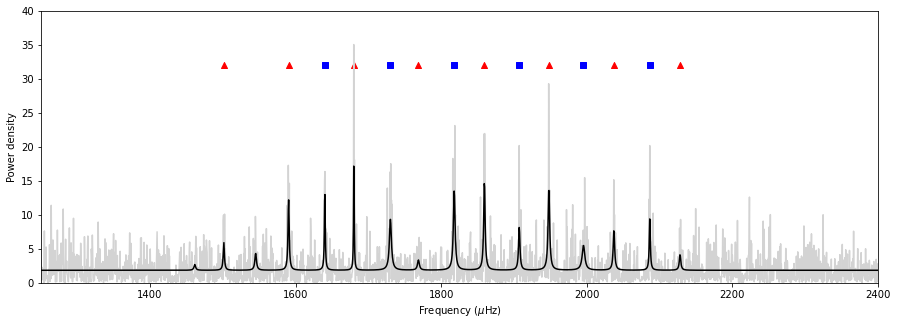

In [123]:
fig, axes = plt.subplots(figsize=[15,5], nrows=1, ncols=1, squeeze=False)
axes = axes.reshape(-1)
axes[0].plot(data['freq'], data['psd'], c='lightgray')
# axes[0].plot(data['freq'], data['psds'])
axes[0].set_xlim(1250,2400)
axes[0].set_ylim(0,40)
axes[0].plot(x, yfit, c='k')


fc0 = np.array([paramsMedian[f'fc0[{imode}]'] for imode in [2,3,4,5,6,7]])
e_fc0 = np.array([paramsErr[f'fc0[{imode}]'] for imode in [2,3,4,5,6,7]])

fc1 = np.array([paramsMedian[f'fc1[{imode}]'] for imode in [0,1,2,3,4,5,6,7]])
e_fc1 = np.array([paramsErr[f'fc1[{imode}]'] for imode in [0,1,2,3,4,5,6,7]])

axes[0].scatter(fc0, [axes[0].get_ylim()[1]*0.8]*len(fc0), c='b', marker='s')
axes[0].scatter(fc1, [axes[0].get_ylim()[1]*0.8]*len(fc1), c='r', marker='^')

axes[0].set_ylabel('Power density')
axes[0].set_xlabel('Frequency ($\\mu$Hz)')
plt.savefig('plot_ps.jpg')

In [10]:
params

,median,mad,eti_3%,eti_97%,mcse_median,ess_median,ess_tail,r_hat
A[0],3.621,0.394,2.747,5.066,0.057,162.375,810.0,1.03
w[0],300.093,50.596,205.946,538.652,0.667,18691.603,19714.0,1.00
fc0[0],1461.372,1.936,1453.722,1465.500,0.032,14945.708,23690.0,1.00
fc0[1],1544.980,0.935,1543.085,1557.082,0.012,15785.194,13386.0,1.00
fc0[2],1640.035,0.265,1639.291,1640.956,0.003,32882.020,21285.0,1.00
fc0[3],1730.130,0.540,1728.068,1731.481,0.007,26794.829,20074.0,1.00
fc0[4],1817.786,0.425,1816.565,1819.001,0.004,32087.242,12280.0,1.00
fc0[5],1907.177,0.412,1905.766,1908.987,0.004,31851.486,10497.0,1.00
fc0[6],1995.406,1.102,1992.097,1998.056,0.012,28658.519,27602.0,1.00
fc0[7],2086.521,0.335,2085.529,2087.867,0.003,31832.700,17929.0,1.00


In [20]:
# params.to_csv('pkbg.csv')
# (2086.521-1640.035)/5
# Dnu = 89.297
Dnu, e_Dnu = 89.5, 0.5

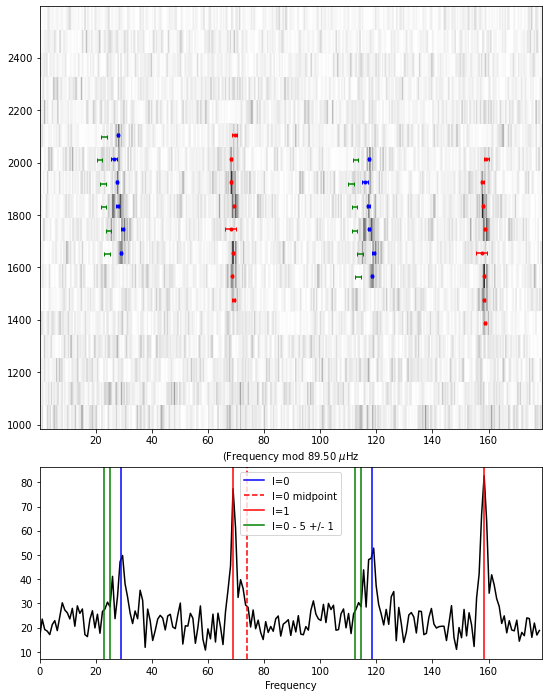

In [22]:
fig = plt.figure(figsize=(9,12))
ax1 = fig.add_subplot(3, 1, (1, 2))
echx, echy, echz = se.echelle(data['freq'].to_numpy(),
                              data['psds'].to_numpy(),
                              Dnu, 
                              numax-9.0*Dnu,
                              numax+9.0*Dnu,
                              echelletype="replicated",
                              offset=0.)
levels = np.linspace(np.min(echz),np.max(echz),500)
ax1.contourf(echx,echy,echz,cmap="gray_r",levels=levels)
ax1.axis([np.min(echx),np.max(echx),np.min(echy),np.max(echy)])

ax1.set_xlabel("Frequency mod {:0.2f} $\mu$Hz".format(Dnu))


fc0 = np.array([paramsMedian[f'fc0[{imode}]'] for imode in [2,3,4,5,6,7]])
e_fc0 = np.array([paramsErr[f'fc0[{imode}]'] for imode in [2,3,4,5,6,7]])

fc1 = np.array([paramsMedian[f'fc1[{imode}]'] for imode in [0,1,2,3,4,5,6,7]])
e_fc1 = np.array([paramsErr[f'fc1[{imode}]'] for imode in [0,1,2,3,4,5,6,7]])

ax1.errorbar(fc0%Dnu, fc0-fc0%Dnu+0.5*Dnu, xerr=e_fc0, marker='.', color='b', linestyle='none', capsize=2)
ax1.errorbar(fc1%Dnu, fc1-fc1%Dnu+0.5*Dnu, xerr=e_fc1,  marker='.', color='r', linestyle='none', capsize=2)
ax1.errorbar(fc0%Dnu+Dnu, fc0-fc0%Dnu-0.5*Dnu, xerr=e_fc0, marker='.', color='b', linestyle='none', capsize=2)
ax1.errorbar(fc1%Dnu+Dnu, fc1-fc1%Dnu-0.5*Dnu, xerr=e_fc1, marker='.', color='r', linestyle='none', capsize=2)

ax1.errorbar(fc0%Dnu-5, fc0-fc0%Dnu-5+0.5*Dnu, xerr=1, color='g', linestyle='none', capsize=2)
ax1.errorbar(fc0%Dnu+Dnu-5, fc0-fc0%Dnu-5-0.5*Dnu, xerr=1, color='g', linestyle='none', capsize=2)

# collapsed echelle
freqc = np.arange(0, Dnu*2, Dnu/100)
powerc = np.zeros(len(freqc))
fmin = 10*Dnu
for i in range(11):
    powerc += np.interp(fmin+i*Dnu+freqc, data['freq'].to_numpy(), data['psds'].to_numpy())

ax2 = fig.add_subplot(3, 1, 3)
ax2.plot(freqc, powerc, 'k')
ax2.set_xlim(0, 2*Dnu)
ax2.set_xlabel("Frequency")

ax2.axvline(29, color='b', label='l=0')
ax2.axvline(29+Dnu, color='b',)

ax2.axvline(29+Dnu/2., color='r', label='l=0 midpoint', linestyle='--')
ax2.axvline(29+Dnu/2.-5, color='r', label='l=1')
ax2.axvline(29+Dnu/2.+Dnu-5, color='r',)

ax2.axvline(29-5+1, color='g', label='l=0 - 5 +/- 1')
ax2.axvline(29-5-1, color='g')
ax2.axvline(29+Dnu-5+1, color='g',)
ax2.axvline(29+Dnu-5-1, color='g',)

ax2.legend()

plt.savefig('plot_echelle.jpg')

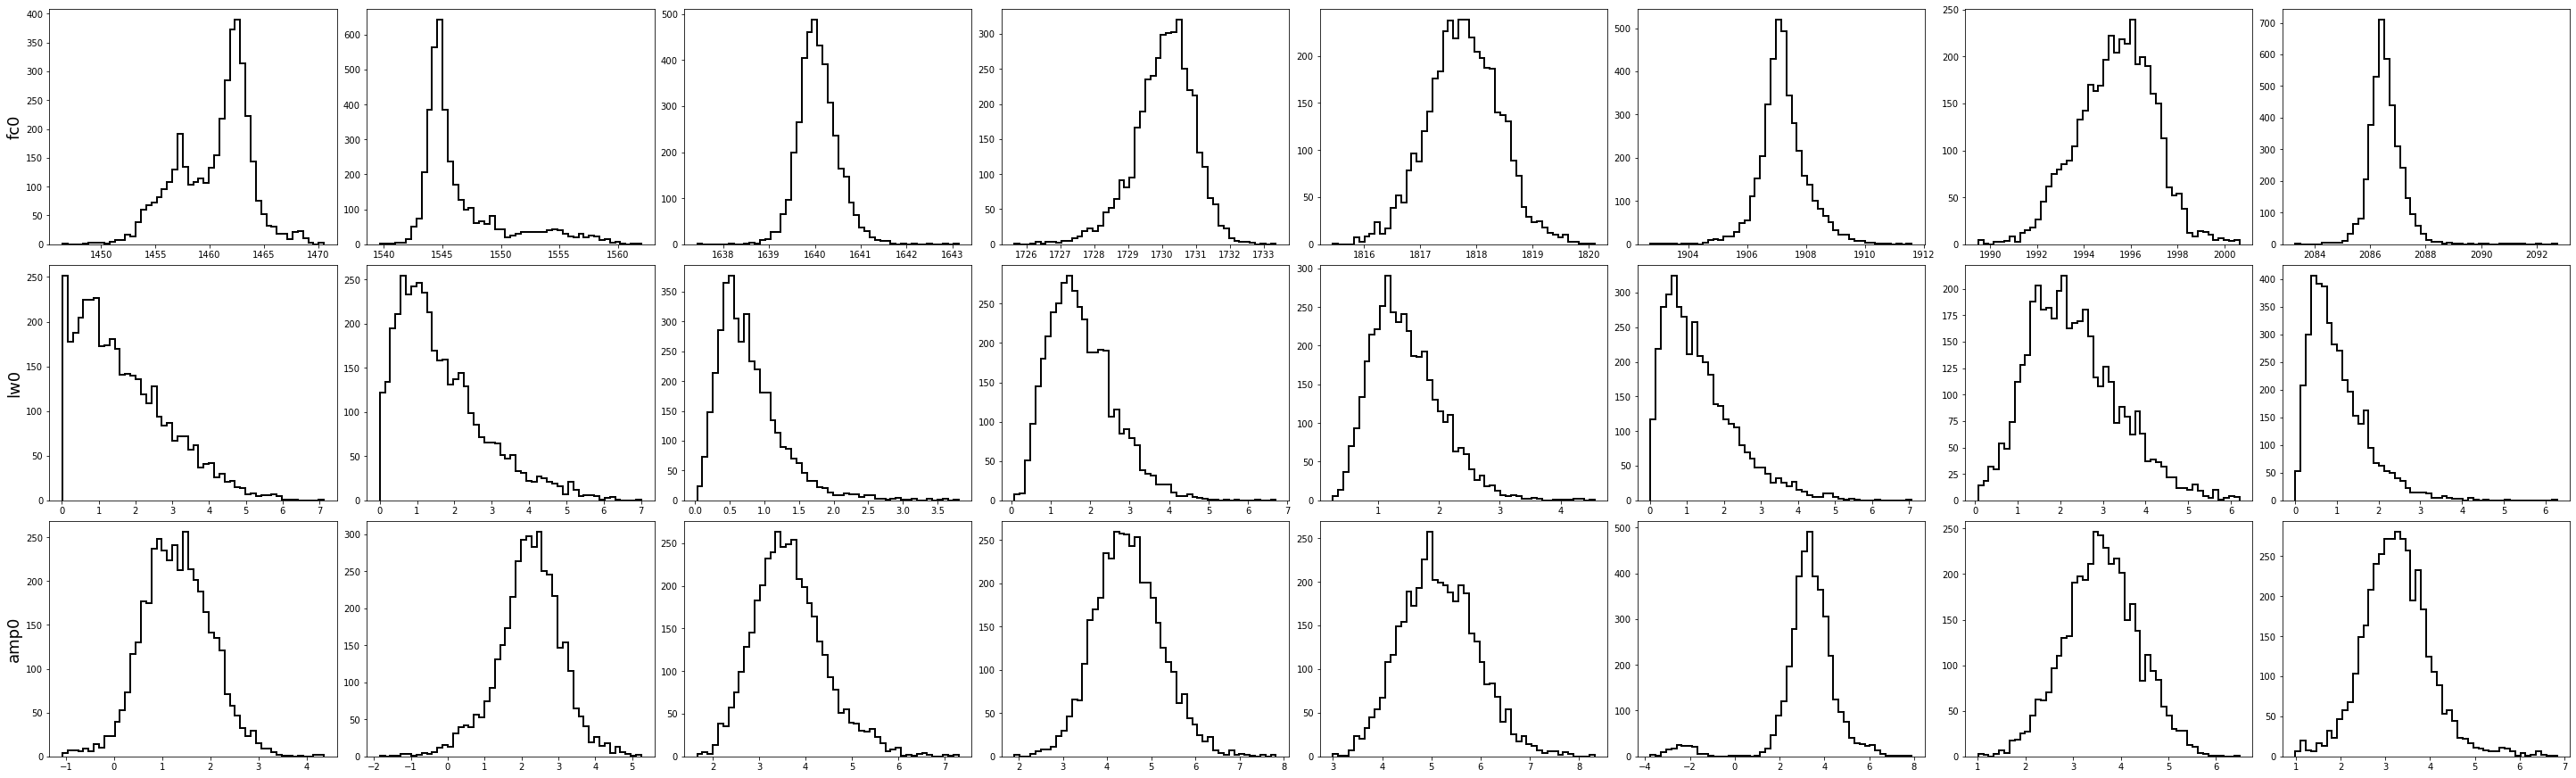

In [53]:
# ifreject = np.zeros(Nmode, dtype=bool)
kwargs = {'histtype':'step', 'linewidth':2, 'color':'k'}
Nmode = 8
fig, axes = plt.subplots(figsize=[Nmode*5, 3*4], nrows=3, ncols=Nmode, squeeze=False, constrained_layout=True)
for imode in range(Nmode):
    data = idata.posterior['fc0'][:,-1000:,imode].to_numpy().reshape(-1)
    axes[0,imode].hist(data, bins=50, **kwargs)
    
    data = idata.posterior['lw0'][:,-1000:,imode].to_numpy().reshape(-1)
    axes[1,imode].hist(data, bins=50, **kwargs)
    
    data = idata.posterior['amp0'][:,-1000:,imode].to_numpy().reshape(-1)
    axes[2,imode].hist(data, bins=50, **kwargs)
    # data = (data-np.median(data))/np.std(data)
    # pvalue = scipy.stats.kstest(data, 'norm')[1]
    # ifreject[imode] = pvalue<0.05
# ifreject
axes[0,0].set_ylabel('fc0', fontsize=18)
axes[1,0].set_ylabel('lw0', fontsize=18)
axes[2,0].set_ylabel('amp0', fontsize=18)

plt.savefig('plot_l0.png')

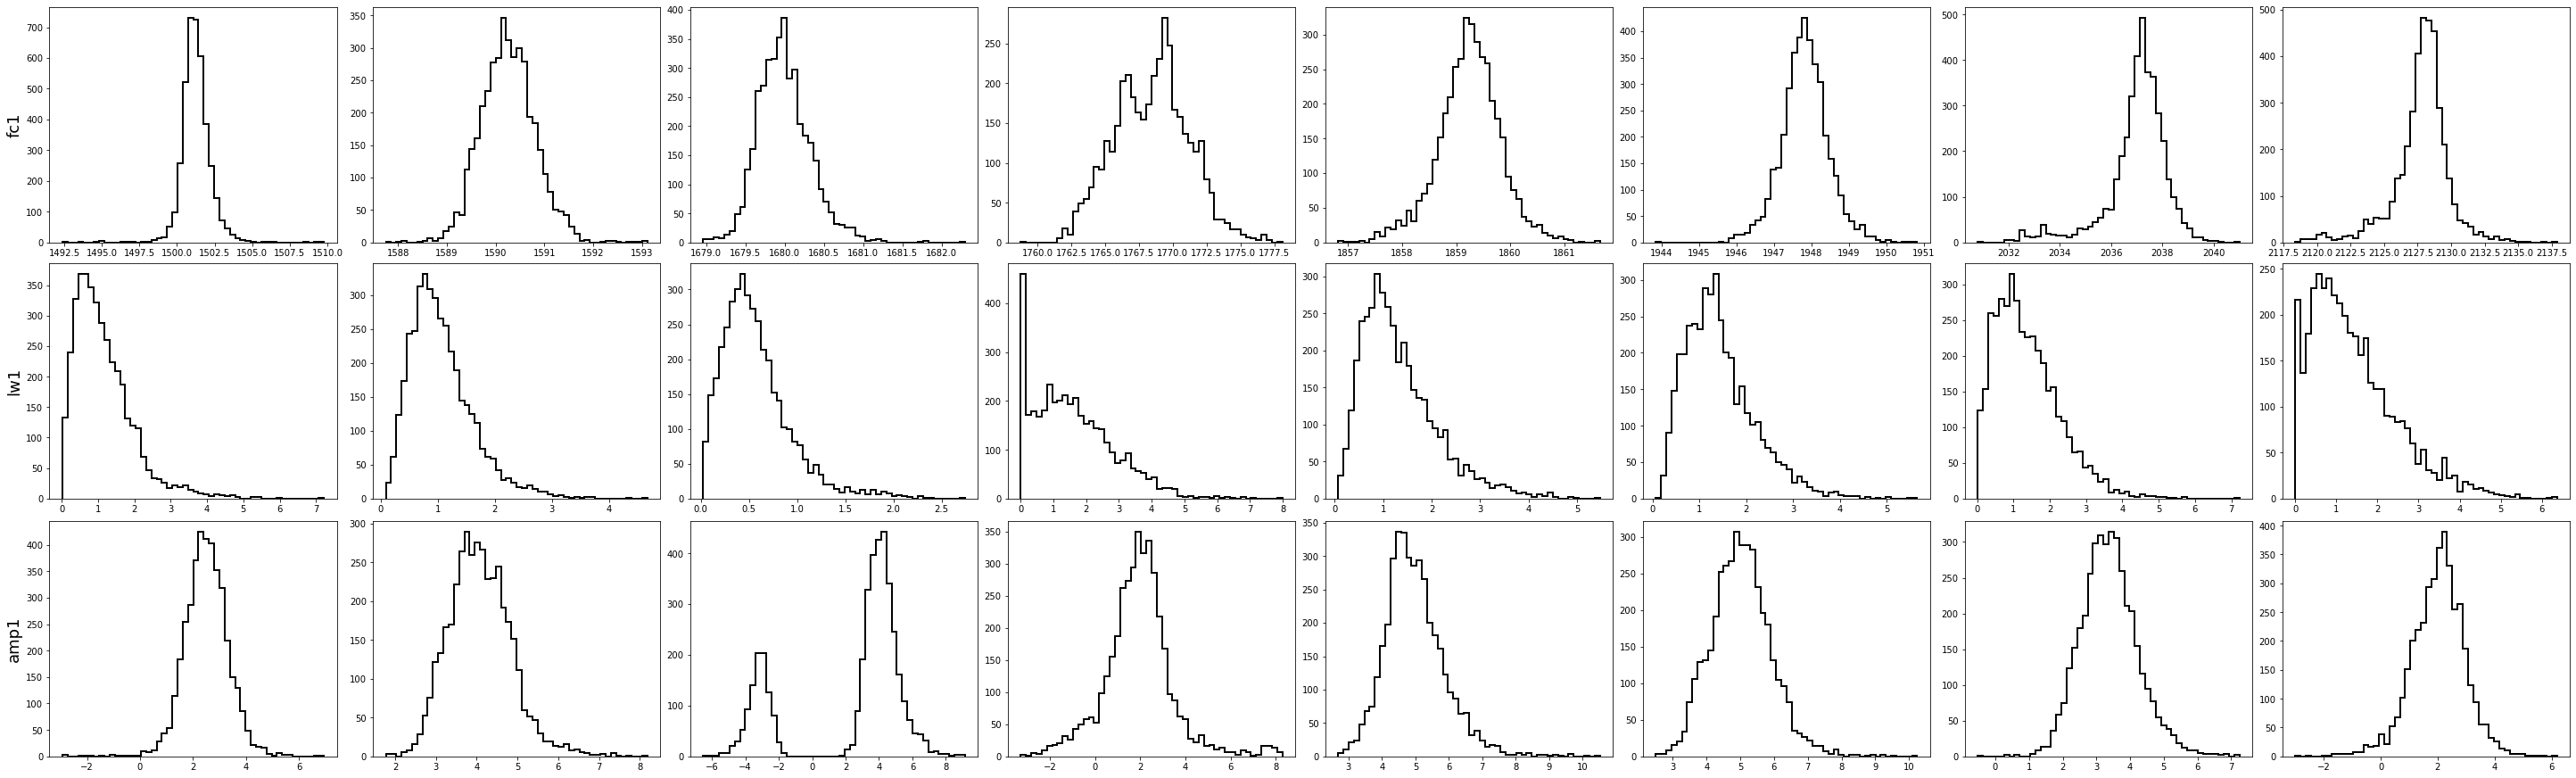

In [54]:
fig, axes = plt.subplots(figsize=[Nmode*5, 3*4], nrows=3, ncols=Nmode, squeeze=False, constrained_layout=True)
kwargs = {'histtype':'step', 'linewidth':2, 'color':'k'}
for imode in range(Nmode):
    data = idata.posterior['fc1'][:,-1000:,imode].to_numpy().reshape(-1)
    axes[0,imode].hist(data, bins=50, **kwargs)
    
    data = idata.posterior['lw1'][:,-1000:,imode].to_numpy().reshape(-1)
    axes[1,imode].hist(data, bins=50, **kwargs)
    
    data = idata.posterior['amp1'][:,-1000:,imode].to_numpy().reshape(-1)
    axes[2,imode].hist(data, bins=50, **kwargs)
    
axes[0,0].set_ylabel('fc1', fontsize=18)
axes[1,0].set_ylabel('lw1', fontsize=18)
axes[2,0].set_ylabel('amp1', fontsize=18)

plt.savefig('plot_l1.png')

In [58]:
params.to_csv('pkbg.csv')